In [350]:
import sys
sys.path.append("..")
import pickle
import cv2
import matplotlib.pyplot as plt
from mvt.utils import draw_boxes, draw_motion_vectors
import seaborn as sns
import numpy as np
import math
import torch

In [351]:
def get_nonzero_vectors(motion_vectors):
    """Returns subset of motion vectors which have non-zero magnitude.
    """
    if np.shape(motion_vectors)[0] == 0:
        return motion_vectors
    else:
        idx = np.where(np.logical_or(motion_vectors[:, 7] != 0, motion_vectors[:, 8] != 0))[0]
        return motion_vectors[idx, :]
    
def draw_motion_vectors(frame, motion_vectors):
    if np.shape(motion_vectors)[0] > 0:
        num_mvs = np.shape(motion_vectors)[0]
        for mv in np.split(motion_vectors, num_mvs):
            start_pt = (mv[0, 3], mv[0, 4])
            end_pt = (mv[0, 5], mv[0, 6])
            if mv[0, 0] < 0:
                cv2.arrowedLine(frame, start_pt, end_pt, (0, 0, 255), 1, cv2.LINE_AA, 0, 0.3)
            else:
                cv2.arrowedLine(frame, start_pt, end_pt, (0, 255, 0), 1, cv2.LINE_AA, 0, 0.3)
    return frame

In [352]:
motion_vectors = pickle.load(open("motion_vectors_h264.pkl", "rb"))

In [353]:
motion_vectors.shape

(6370, 10)

In [354]:
def motion_vectors_to_image(motion_vectors, frame_shape=(1920, 1080)):
    """Converts a set of motion vectors into a BGR image.
    
    Args:
        motion_vectors (`numpy.ndarray`): Motion vector array with shape [N, 10]
            as returned by VideoCap. The motion vector array should only contain P-vectors
            which can be filtered out by using get_vectors_by_source(motion_vectors, "past").
            Also, the reference frame should be normalized by using normalize_vectors.
        
        frame_shape (`tuple` of `int`): Desired (width, height) in pixels of the returned image.
            Should correspond to the size of the source footage of which the motion vectors
            where extracted.
    
    Returns:
        `numpy.ndarray` The motion vectors encoded as image. Image shape is (height, widht, 3)
        and channel order is BGR. The red channel contains the scaled x motion components of 
        the motion vectors and the green channel the scaled y motion components. Scaled means
        the motion components are normalized to range [0, 1].
    """
    
    # process non-zero vectors only to speed up computations below
    motion_vectors = get_nonzero_vectors(motion_vectors)
    
    # compute necessary frame shape
    frame_shape = (1920, 1080)
    need_width = math.ceil(frame_shape[0] / 16) * 16
    need_height = math.ceil(frame_shape[1] / 16) * 16

    image = np.zeros((need_height, need_width, 3), dtype=np.float32)

    # get minimum and maximum values
    mvs_dst_x = motion_vectors[:, 5]
    mvs_dst_y = motion_vectors[:, 6]
    mb_w = motion_vectors[:, 1]
    mb_h = motion_vectors[:, 2]
    mvs_tl_x = (mvs_dst_x - 0.5 * mb_w).astype(np.int64)
    mvs_tl_y = (mvs_dst_y - 0.5 * mb_h).astype(np.int64)

    # compute value
    mvs_motion_x = (motion_vectors[:, 7] / motion_vectors[:, 9]).reshape(-1, 1)
    mvs_motion_y = (motion_vectors[:, 8] / motion_vectors[:, 9]).reshape(-1, 1)

    mvs_min_x = np.min(mvs_motion_x)
    mvs_max_x = np.max(mvs_motion_x)
    mvs_min_y = np.min(mvs_motion_y)
    mvs_max_y = np.max(mvs_motion_y)

    mvs_motion_x = (mvs_motion_x - mvs_min_x) / (mvs_max_x - mvs_min_x)
    mvs_motion_y = (mvs_motion_y - mvs_min_y) / (mvs_max_y - mvs_min_y)

    for i, motion_vector in enumerate(motion_vectors):
        # repeat value
        mvs_motion_x_repeated = np.repeat(np.repeat(mvs_motion_x[i, :].reshape(1, 1), mb_h[i], axis=0), mb_w[i], axis=1)
        mvs_motion_y_repeated = np.repeat(np.repeat(mvs_motion_y[i, :].reshape(1, 1), mb_h[i], axis=0), mb_w[i], axis=1)

        # insert repeated block into image
        image[mvs_tl_y[i]:mvs_tl_y[i]+mb_h[i], mvs_tl_x[i]:mvs_tl_x[i]+mb_w[i], 2] = mvs_motion_x_repeated
        image[mvs_tl_y[i]:mvs_tl_y[i]+mb_h[i], mvs_tl_x[i]:mvs_tl_x[i]+mb_w[i], 1] = mvs_motion_y_repeated

    # crop the image back to frame_shape
    image = image[0:frame_shape[1], 0:frame_shape[0], :]
    
    return image

image = motion_vectors_to_image(motion_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


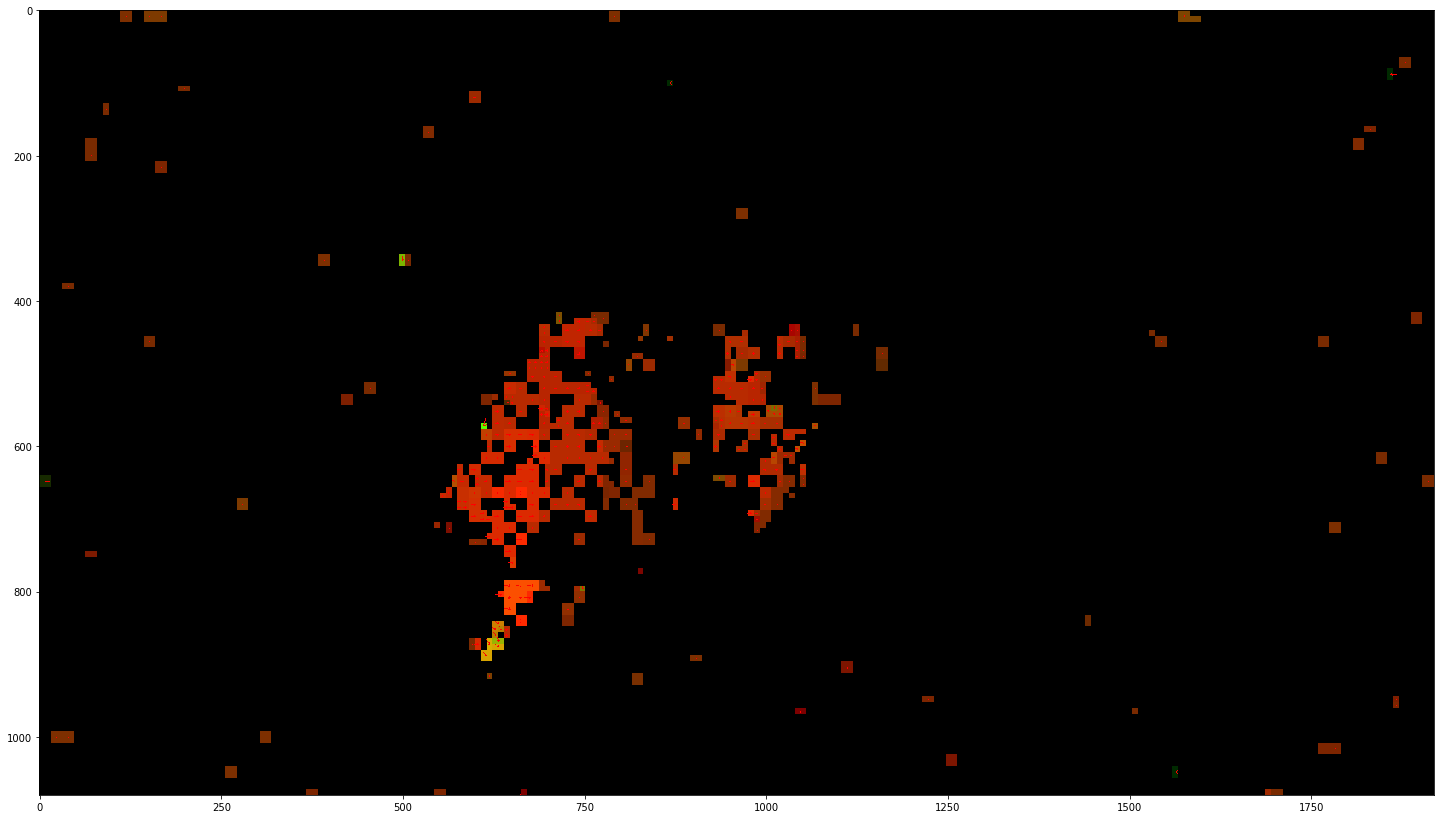

In [355]:
image = draw_motion_vectors(image, get_nonzero_vectors(motion_vectors))


image[:, :, [0, 1, 2]] = image[:, :, [2, 1, 0]] # matplotlib needs RGB channel order
f, ax = plt.subplots(figsize=(25,25))
ax.imshow(image)
plt.show()